In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import pandas as pd
from src.preprocess import *
from tqdm import tqdm
import osmnx as ox

## Noise barriers

In [2]:
pictures = gpd.read_file("data/podzial_na_obrazki.csv")
noise_barriers_1 = gpd.read_file('data/NOISE_BARRIERS.zip')
noise_barriers_2 = gpd.read_file('data/NOISE_BARRIERS_2.zip')

In [3]:
noise_barriers_1.drop(columns='ID_CLONA', inplace=True)
noise_barriers_2.drop(columns='ID_VAL', inplace=True)

In [4]:
noise_barriers = pd.concat([noise_barriers_1, noise_barriers_2]).reset_index(drop = True)

In [5]:
pictures = gpd.GeoDataFrame(pictures).rename(columns={0: "geometry"})
pictures["geometry"] = pictures["geometry"].apply(parse_polygon)
# df = pictures.dropna(subset=["geometry"])
pictures.set_geometry('geometry', inplace=True)

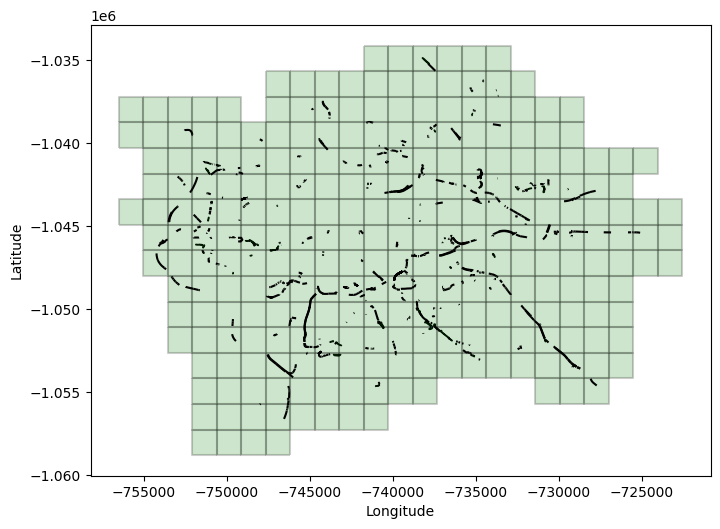

In [6]:
fig, ax = plt.subplots(figsize=(8, 8))

noise_barriers.plot(
    k=noise_barriers.shape[0],
    edgecolor="black",
    ax=ax,
)


pictures.plot(ax=ax, alpha = 0.2, color="green",edgecolor="black", linewidth=1.5)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

In [7]:
picture = pictures['geometry'][100]

In [ ]:
bariers_for_pixel = gpd.clip(noise_barriers, picture)
bariers_for_pixel

,ULICE,POPIS,VYSKA,KAT_UZEMI,GLOBALID,SHAPE_LEN,geometry
33,Pražský okruh,Pražský okruh,2.5,Třebonice,{8AC66918-D19A-4936-8A09-82067F465032},147.214506,"LINESTRING (-753668.289 -1047602.307, -753693...."
32,Pražský okruh,Pražský okruh,2.5,Třebonice,{64DC7777-A23B-421F-8586-F81209061FC3},619.356144,"LINESTRING (-753779.583 -1047508.137, -753781...."
484,Pražský okruh,None,3.0,Třebonice,{4AE00C58-856F-43DB-81B1-41BBC4D761AB},404.699366,"LINESTRING (-754166.627 -1047037.674, -754190...."


In [9]:
pixels = split_polygon(picture, thresh=0.99, number_of_pixels_on_side = 25)
pixels = geopandas.GeoDataFrame(pixels).rename(columns={0: "geometry"})
pixels.set_geometry('geometry', inplace=True)

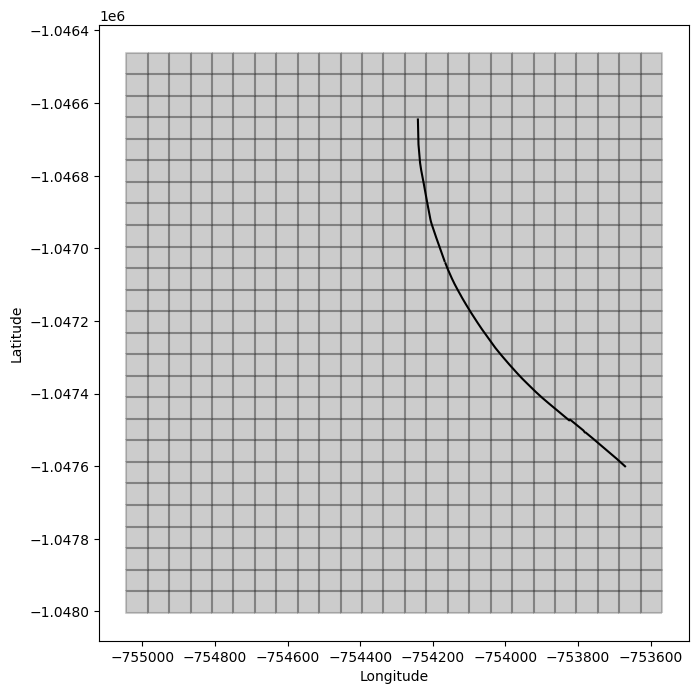

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))

bariers_for_pixel.plot(ax=ax, alpha = 1, color="black",edgecolor="black", linewidth=1.5)
pixels.plot(ax=ax, alpha = 0.2, color="black",edgecolor="black", linewidth=1.5)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

In [11]:
pixels['has_barrier'] = pixels.geometry.apply(
    lambda square: 1 if bariers_for_pixel.geometry.intersects(square).any() else 0
)


In [12]:
def get_barrier(pixel, bariers_for_pixel):
    if bariers_for_pixel.geometry.intersects(pixel).any():
        return 1
    else:
        return 0

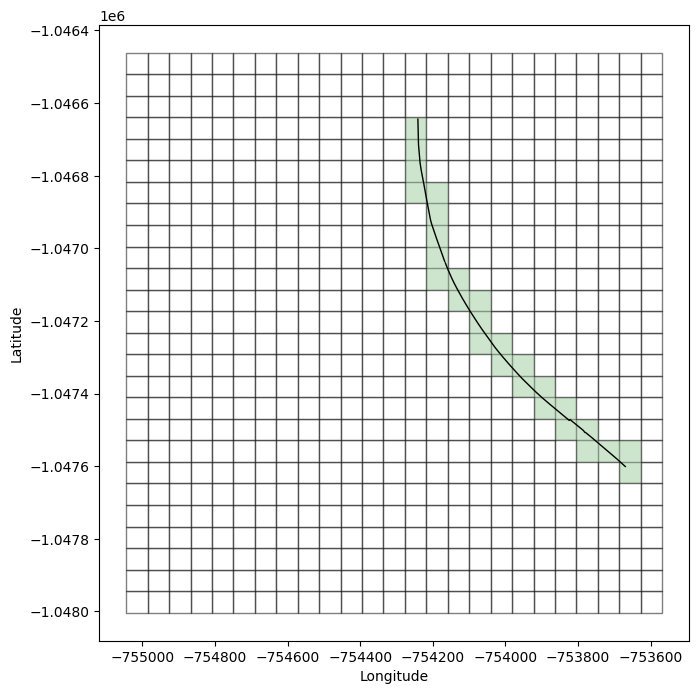

In [13]:
fig, ax = plt.subplots(figsize=(8, 8))

bariers_for_pixel.plot(ax=ax, color="black", linewidth=1)
pixels[pixels['has_barrier'] == 1].plot(ax=ax, color="green", edgecolor="black", alpha=0.2)
pixels[pixels['has_barrier'] == 0].plot(ax=ax, color="white", edgecolor="black", alpha=0.5)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

In [14]:
def aggregate_noise_barier_data(picture):
    bariers_for_pixel = gpd.clip(noise_barriers, picture)
    pixels = split_polygon(picture, thresh=0.99, number_of_pixels_on_side = 25)
    pixels = geopandas.GeoDataFrame(pixels).rename(columns={0: "geometry"})
    pixels.set_geometry('geometry', inplace=True)
    pixels['has_barrier'] = pixels.geometry.apply(
        lambda square: 1 if bariers_for_pixel.geometry.intersects(square).any() else 0
    )
    return pixels


def plot_agg(picture, pixels):
    fig, ax = plt.subplots(figsize=(8, 8))

    bariers_for_pixel = gpd.clip(noise_barriers, picture)
    bariers_for_pixel.plot(ax=ax, color="black", linewidth=1)
    pixels[pixels['has_barrier'] == 1].plot(ax=ax, color="green", edgecolor="black", alpha=0.2)
    pixels[pixels['has_barrier']== 0].plot(ax=ax, color="white", edgecolor="black", alpha=0.5)

    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    plt.show()

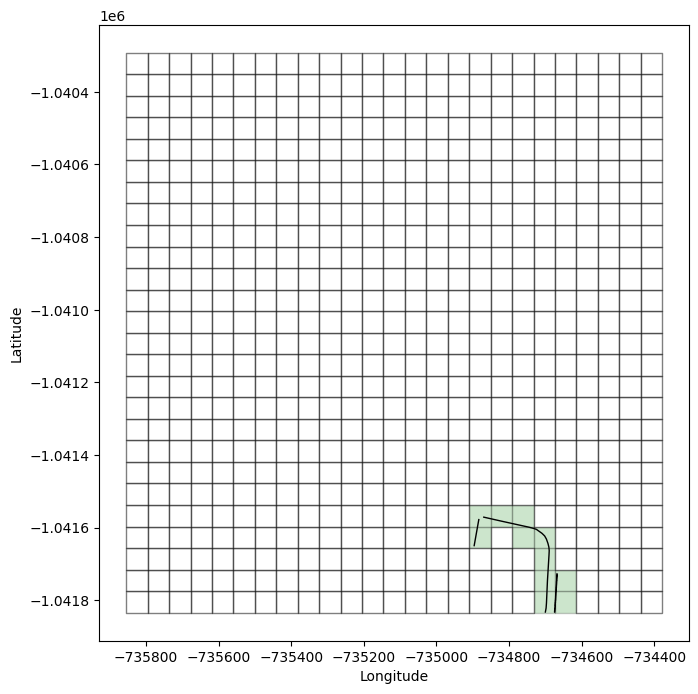

In [15]:
picture_2 = pictures['geometry'][200]
pixels_2 = aggregate_noise_barier_data(picture_2)
plot_agg(picture_2, pixels_2)

## Buildings

In [16]:
def download_buildings():
    city = 'Praha'
    buildings = ox.features_from_place(city, tags={'building': True})
    buildings = buildings[['geometry', 'building:levels']]
    buildings = buildings[(buildings["building:levels"].notna())]
    buildings["building:levels"] = pd.to_numeric(buildings["building:levels"], errors='coerce')
    buildings = buildings[buildings["building:levels"].notna()]
    buildings = buildings[buildings.geometry.type.isin(["Polygon", "MultiPolygon"])]
    buildings = buildings.rename(columns={'building:levels': 'buildings_levels'})
    return buildings

In [17]:
buildings = download_buildings()

In [18]:
buildings = buildings.to_crs(noise_barriers.crs)

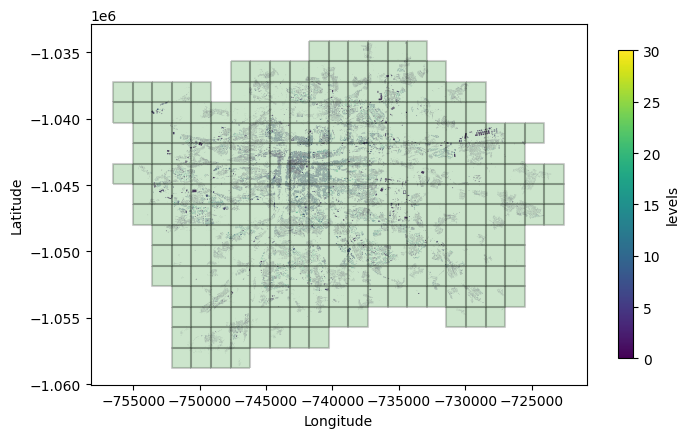

In [19]:
fig, ax = plt.subplots(figsize=(8, 8))

buildings.plot(column='buildings_levels', 
        legend=True,
        alpha=0.9, 
        ax=ax,
        legend_kwds={'shrink': 0.5, 'label': 'levels'}
)


pictures.plot(ax=ax, alpha = 0.2, color="green",edgecolor="black", linewidth=1.5)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

In [20]:
picture = pictures['geometry'][1]

In [21]:
buildings_for_pixel = gpd.clip(buildings, picture)
pixels = split_polygon(picture, thresh=0.99, number_of_pixels_on_side = 25)
pixels = geopandas.GeoDataFrame(pixels).rename(columns={0: "geometry"})
pixels.set_geometry('geometry', inplace=True)

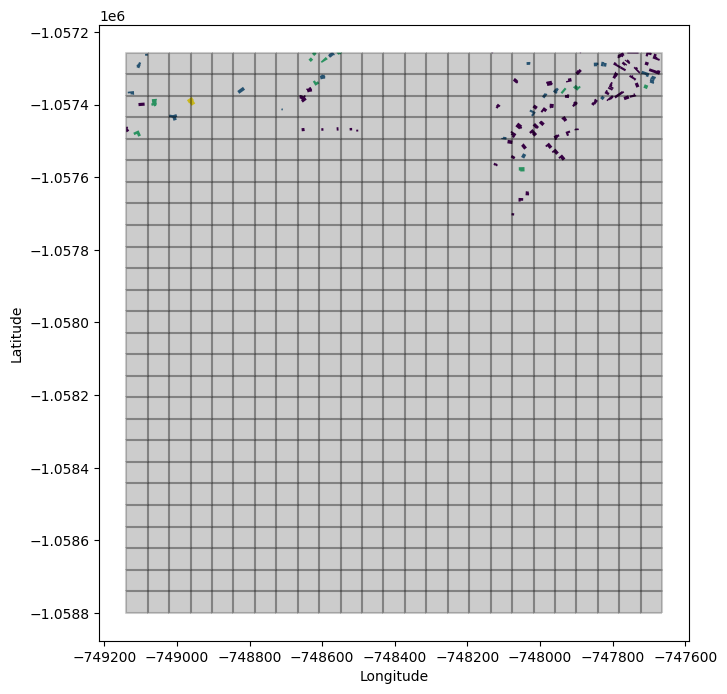

In [22]:
fig, ax = plt.subplots(figsize=(8, 8))

buildings_for_pixel.plot(ax=ax,column='buildings_levels')
pixels.plot(ax=ax, alpha = 0.2, color="black",edgecolor="black", linewidth=1.5)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

In [23]:
def get_buildings_levels(pixel, buildings_for_pixel):
    intersecting_buildings = buildings_for_pixel[buildings_for_pixel.geometry.intersects(pixel)]
    
    if not intersecting_buildings.empty:
        intersecting_buildings['intersected_area'] = intersecting_buildings.geometry.intersection(pixel).area
        area_by_levels = intersecting_buildings.groupby('buildings_levels')['intersected_area'].sum()
        max_levels = area_by_levels.idxmax()
        return max_levels
    
    else:
        return 0


In [24]:
pixels

,geometry
0,"POLYGON ((-747663.568 -1058799.6, -747722.613 ..."
1,"POLYGON ((-747722.613 -1058799.6, -747781.659 ..."
2,"POLYGON ((-747781.659 -1058799.6, -747840.704 ..."
3,"POLYGON ((-747840.704 -1058799.6, -747899.75 -..."
4,"POLYGON ((-747899.75 -1058799.6, -747958.796 -..."
...,...
645,"POLYGON ((-747958.796 -1057257.329, -747899.75..."
646,"POLYGON ((-747899.75 -1057257.329, -747840.704..."
647,"POLYGON ((-747840.704 -1057257.329, -747781.65..."
648,"POLYGON ((-747781.659 -1057257.329, -747722.61..."


In [25]:
pixels['buildings_levels'] = pixels.apply(lambda row: get_buildings_levels(row.geometry, buildings_for_pixel), axis=1)

In [26]:
pixels

,geometry,buildings_levels
0,"POLYGON ((-747663.568 -1058799.6, -747722.613 ...",0.0
1,"POLYGON ((-747722.613 -1058799.6, -747781.659 ...",0.0
2,"POLYGON ((-747781.659 -1058799.6, -747840.704 ...",0.0
3,"POLYGON ((-747840.704 -1058799.6, -747899.75 -...",0.0
4,"POLYGON ((-747899.75 -1058799.6, -747958.796 -...",0.0
...,...,...
645,"POLYGON ((-747958.796 -1057257.329, -747899.75...",1.0
646,"POLYGON ((-747899.75 -1057257.329, -747840.704...",1.0
647,"POLYGON ((-747840.704 -1057257.329, -747781.65...",1.0
648,"POLYGON ((-747781.659 -1057257.329, -747722.61...",1.0


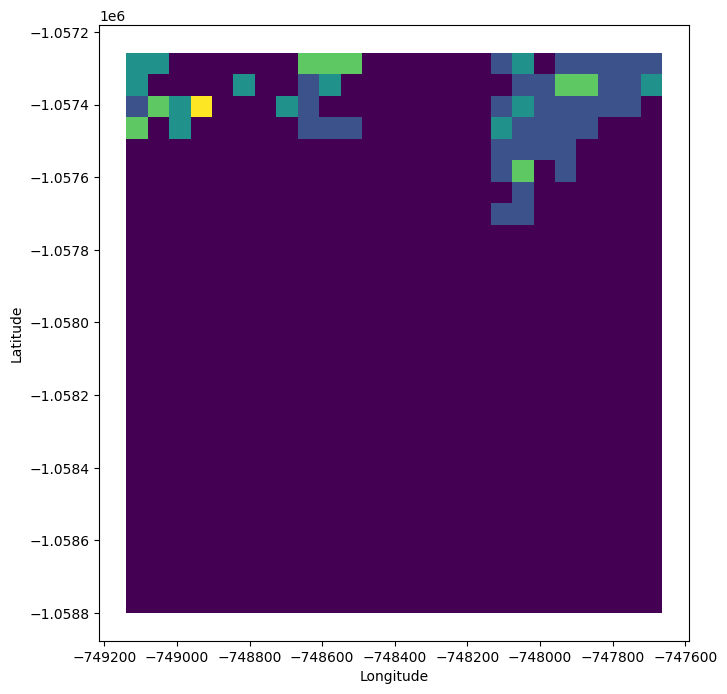

In [27]:
fig, ax = plt.subplots(figsize=(8, 8))

pixels.plot(
    column='buildings_levels',
    cmap="viridis",
    ax=ax,
    linewidth=0.0,
    edgecolor="0.8"
)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

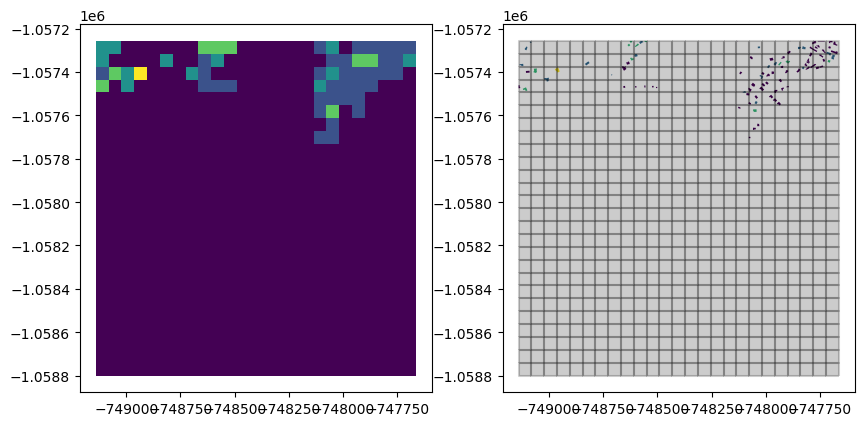

In [28]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 10))


pixels.plot(
    column='buildings_levels',
    cmap="viridis",
    ax=ax[0],
    linewidth=0.0,
    edgecolor="0.8"
)

buildings_for_pixel.plot(
    column="buildings_levels",
    cmap="viridis",
    linewidth=0.0,
    alpha=1,
    ax=ax[1],
)

pixels.plot(ax=ax[1], alpha = 0.2, color="black",edgecolor="black", linewidth=1.5)


plt.show()

In [29]:
def aggregate_buildings_levels(picture):
    buildings_for_pixel = gpd.clip(buildings, picture)
    pixels = split_polygon(picture, thresh=0.99, number_of_pixels_on_side = 25)
    pixels = geopandas.GeoDataFrame(pixels).rename(columns={0: "geometry"})
    pixels.set_geometry('geometry', inplace=True)
    pixels['buildings_levels'] = pixels.apply(lambda row: get_buildings_levels(row.geometry, buildings_for_pixel), axis=1)
    return pixels


def plot_agg_buildings(pixels):
    fig, ax = plt.subplots(figsize=(8, 8))

    pixels.plot(
        column='buildings_levels',
        cmap="viridis",
        ax=ax,
        linewidth=0.0,
        edgecolor="0.8"
    )
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.show()

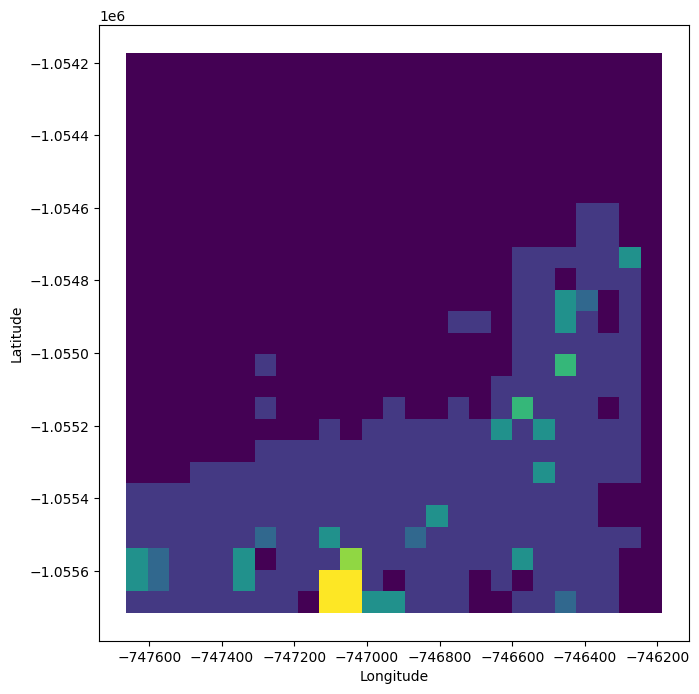

In [30]:
p = pictures['geometry'][15]
pix = aggregate_buildings_levels(p)
plot_agg_buildings(pix)